In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

data_source = 'wine.data'
d = pd.read_table(data_source, delimiter=',',
                  header=None,
                  names=['class','alcohol','malic_acid',
                         'ash','alcalinity_of_ash','magnesium',
                         'total_phenols','flavanoids','nonflavanoid_phenols',
                         'proanthocyanins','color_intensity','hue',
                         'od280/od315','proline'])
dx = d.iloc[ : , 1:5 ]
dy = d['class']
print(dx.head())
print(dy.head())

   alcohol  malic_acid   ash  alcalinity_of_ash
0    14.23        1.71  2.43               15.6
1    13.20        1.78  2.14               11.2
2    13.16        2.36  2.67               18.6
3    14.37        1.95  2.50               16.8
4    13.24        2.59  2.87               21.0
0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x_train, x_holdout, y_train, y_holdout = \
train_test_split(dx, dy, test_size=0.3, random_state=12)

tree = DecisionTreeClassifier(max_depth=5,
                              random_state=21,
                              max_features=2)
tree.fit(x_train, y_train)

tree_pred = tree.predict(x_holdout)
accur = accuracy_score(y_holdout, tree_pred)
print(accur)

0.7592592592592593


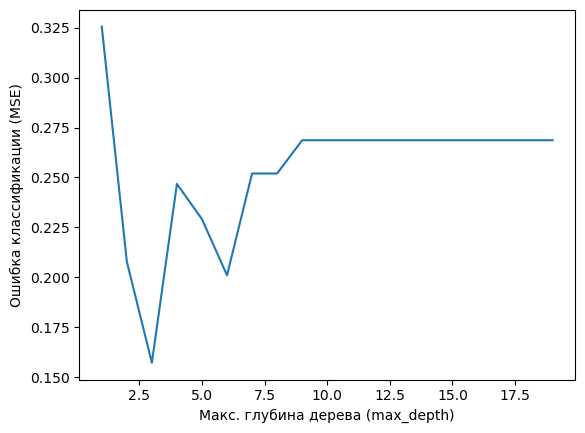

Оптимальные значения max_depth:  [3]


In [20]:
from sklearn.model_selection import cross_val_score

d_list = list(range(1,20))
cv_scores = []
for d in d_list:
    tree = DecisionTreeClassifier(max_depth=d,
                                  random_state=21,
                                  max_features=2)
    scores = cross_val_score(tree, dx, dy, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1-x for x in cv_scores]

plt.plot(d_list, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

d_min = min(MSE)

all_d_min = []
for i in range(len(MSE)):
    if MSE[i] <= d_min:
        all_d_min.append(d_list[i])

print('Оптимальные значения max_depth: ', all_d_min)

In [24]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import tree

dtc = DecisionTreeClassifier(max_depth=10, random_state=21, max_features=2)

tree_params = { 'max_depth': range(1,20), 'max_features': range(1,4) }
tree_grid = GridSearchCV(dtc, tree_params, cv=10, verbose=True, n_jobs=-1)
tree_grid.fit(dx, dy)

print('\n')
print('Лучшее соответствие параметров: ', tree_grid.best_params_)
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

tree.export_graphviz(tree_grid.best_estimator_,
    feature_names=dx.columns,
    class_names=[str(c) for c in dy.unique()],
    out_file='wine_tree.dot',
    filled=True,
    rounded=True
)

Fitting 10 folds for each of 57 candidates, totalling 570 fits


Лучшее соответствие параметров:  {'max_depth': 3, 'max_features': 2}
Лучшие баллы cross validation:  0.8428104575163399


In [26]:
dtc = DecisionTreeClassifier(max_depth=3,
                             random_state=21,
                             max_features=2)
dtc.fit(dx, dy)
res = dtc.predict(pd.DataFrame([[5.1, 3.5, 1.4, 0.2]], columns=dx.columns))
print(res)

[2]


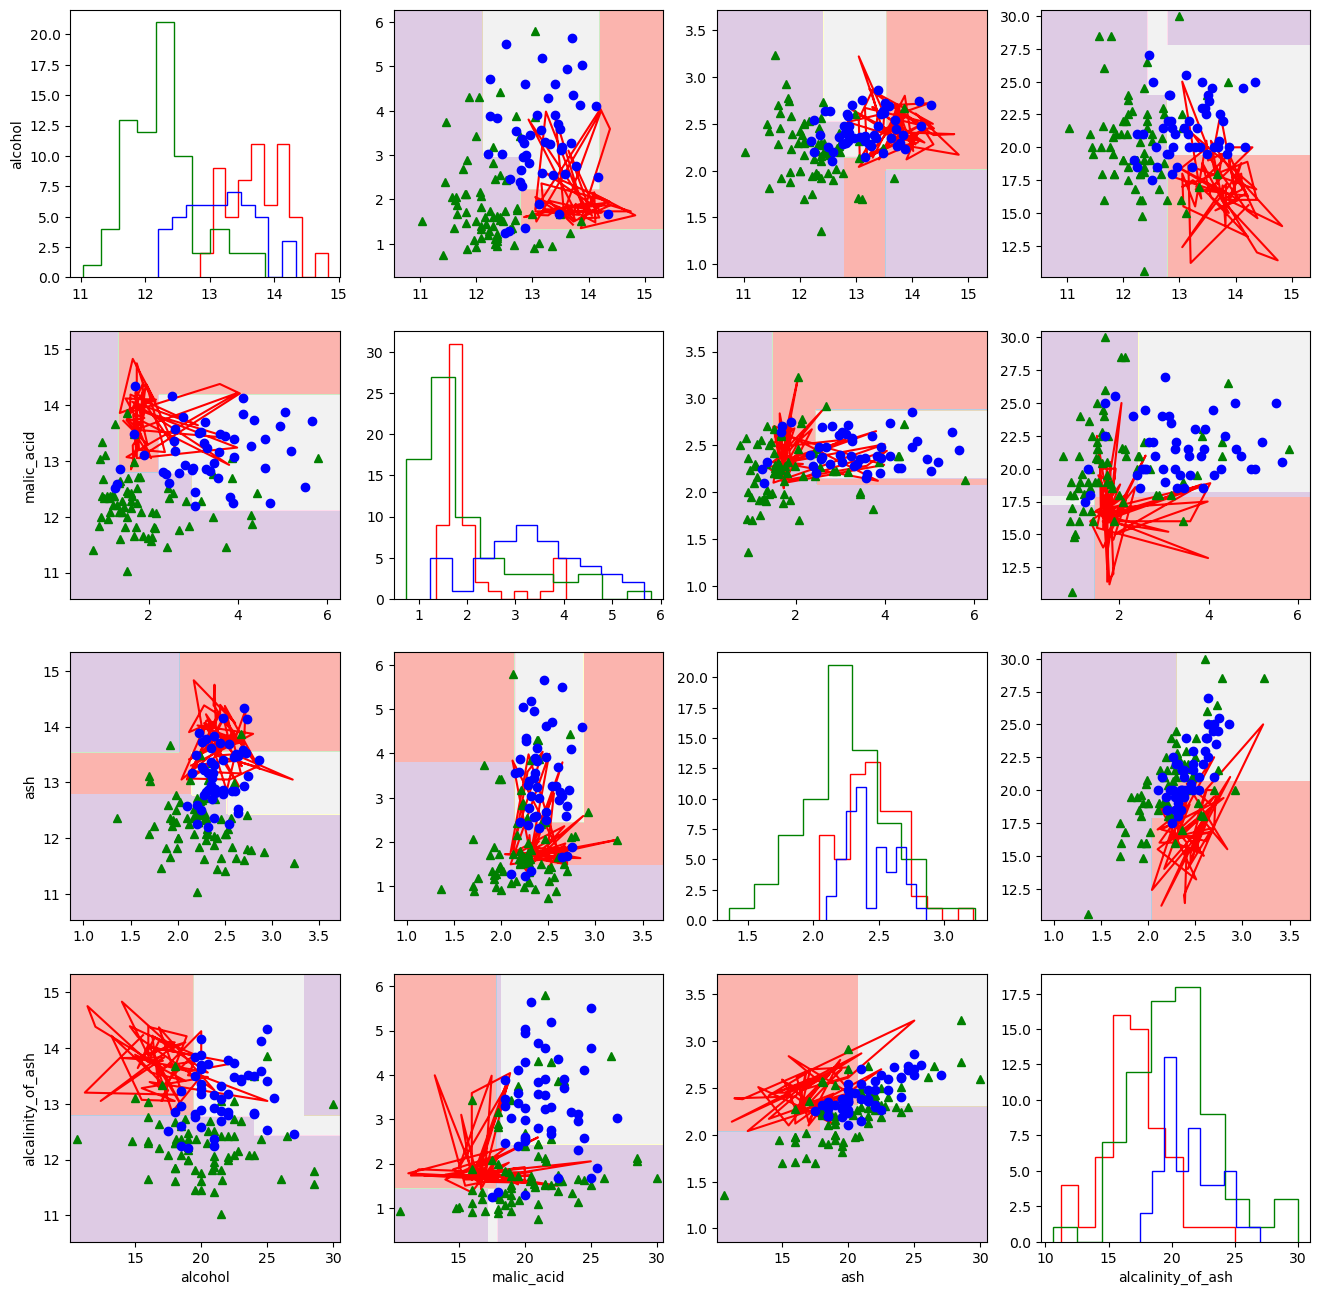

In [31]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

plot_markers = ['r', 'g^', 'bo']
answers = dy.unique()

f, places = plt.subplots(4, 4, figsize=(16,16))

fmin = dx.min() - 0.5
fmax = dx.max() + 0.5
plot_step = 0.02

for i in range(0, 4):
    for j in range(0, 4):

        if i != j:
            xx, yy = np.meshgrid(
                np.arange(fmin.iloc[i], fmax.iloc[i], plot_step),
                np.arange(fmin.iloc[j], fmax.iloc[j], plot_step)
            )

            model = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)

            X_pair = dx.iloc[:, [i, j]]
            model.fit(X_pair, dy)

            p = model.predict(np.c_[xx.ravel(), yy.ravel()])
            p = p.reshape(xx.shape)

            p2 = np.zeros_like(p)
            for ii in range(len(answers)):
                p2[p == answers[ii]] = ii

            places[i, j].contourf(xx, yy, p2, cmap='Pastel1')

        for id_answer in range(len(answers)):
            idx = np.where(dy == answers[id_answer])[0]

            if i == j:
                places[i, j].hist(
                    dx.iloc[idx, i],
                    color=plot_markers[id_answer][0],
                    histtype='step'
                )
            else:
                places[i, j].plot(
                    dx.iloc[idx, i],
                    dx.iloc[idx, j],
                    plot_markers[id_answer],
                    label=answers[id_answer],
                    markersize=6
                )

        if j == 0:
            places[i, j].set_ylabel(dx.columns[i])

        if i == 3:
            places[i, j].set_xlabel(dx.columns[j])